In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import collections

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

from collections import Counter, defaultdict
from operator import itemgetter
from tqdm import tqdm

Loading the adjacency matrix and the sampled data

In [2]:
adjacency_matrix = np.load('adjacency_matrix.npy')

data_recipe = pd.read_json('processed_data.json').reset_index(drop=True)

In [3]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,[In a 1-pint jar with a tight-fitting lid comb...,32,2004-08-20 12:48:48,"[Cheese, Herb, Appetizer, Winter, Gourmet]",306,4,3.750,"Goat Cheese Marinated in Rosemary, Fennel, and...","[log, cheese, goat, oil, fennel, peeler, montr...",106
1,"[Preheat oven to 400°F with rack in middle., T...",7,2008-10-16 04:00:00,"[Side, Roast, Thanksgiving, Vegetarian, Dinner...",168,6,4.375,Parmesan-Roasted Butternut Squash,"[parmigiano-reggiano, piece, sage, squash, cream]",142
2,[Cut an X in bottom of each tomato with a shar...,102,2004-09-21 20:28:40,"[Beef, Potato, Tomato, Bake, Fall, Winter, Gou...",1303,42,3.125,Croatian Moussaka,"[bread, milk, egg, oil, thermometer, butter, p...",713
3,[Heat oil in heavy large pot over medium-heat....,13,2004-09-21 20:28:11,"[Soup/Stew, Pasta, Shellfish, Tomato, Sauté, C...",396,47,4.375,Ann Pachett's Spicy Seafood Chowder,"[bay, side, clam, orzo, parsley, oil, scallop,...",2133
4,[Thinly slice cabbage and onion separately. In...,5,2004-08-20 04:00:00,"[Onion, Side, Quick & Easy, Vinegar, Fall, Cab...",100,2,3.750,Wilted Red Cabbage with Balsamic Vinegar,"[water, cabbage, oil, onion, vinegar, pepper, ...",35


Plotting the adjacency matrix to see sparsity pattern

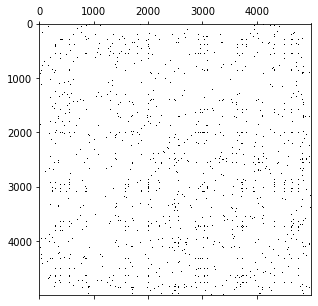

In [4]:
plt.figure(figsize=(5,5))
plt.spy(adjacency_matrix)
plt.show()

In [5]:
def describe_graph(G):
    """
    Helper function for printing various graph properties.
    
    Parameters
    ----------
    
    G: NetworkX graph object
        Graph
    """
    print(nx.info(G))
    if nx.is_connected(G):
        print("Average shortest path length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

Let's create a graph object from our adjacency matrix

In [6]:
graph = nx.from_numpy_array(adjacency_matrix)

In [7]:
describe_graph(graph)

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 243225
Average degree:  97.2900
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0195
Global clustering coefficient aka Transitivity: 0.3501


Creating dictionaries which will map nodes to the corresponding dish names and vice versa

In [8]:
node_label_mapping = dict(zip(range(5000), data_recipe.title))
label_node_mapping = dict(zip(data_recipe.title,range(5000)))

Now, let's add attributes to our graph's nodes

In [9]:
nx.set_node_attributes(graph, data_recipe['protein'].to_dict(), 'protein')
nx.set_node_attributes(graph, data_recipe['fat'].to_dict(), 'fat')
nx.set_node_attributes(graph, data_recipe['sodium'].to_dict(), 'sodium')
nx.set_node_attributes(graph, data_recipe['calories'].to_dict(), 'calories')
nx.set_node_attributes(graph, data_recipe['rating'].to_dict(), 'rating')

An example of a node with its corresponding dish title

In [10]:
print(node_label_mapping[0])
print(graph.node[0])

Goat Cheese Marinated in Rosemary, Fennel, and Hot Red Pepper
{'protein': 4, 'fat': 32, 'sodium': 106, 'calories': 306, 'rating': 3.75}


In [11]:
def visualize_graph(G, signal, with_labels=False, k=None, alpha=1.0, node_shape='o'):
    """
    Helper function for visualizing signal on the graph.

    Parameters
    ----------

    G: NetworkX graph object
        Graph
    
    signal: string
        Node attribute to be used as a graph signal
    
    with_labels: boolean
        Node label
    
    k: float
        Optimal distance between nodes.  If None the distance is set to
        1/sqrt(n) where n is the number of nodes.  Increase this value
        to move nodes farther apart.
        
    alpha: float
        The edge transparency
    
    node_shape: string
        The shape of the node.  Specification is as matplotlib.scatter
        marker, one of 'so^>v<dph8'
    """
    plt.figure(figsize=(15,8))
    plt.title(signal + ' as a signal on the graph')
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[G.nodes[n][signal] for n in G.nodes()], node_shape=node_shape)
    plt.colorbar(nc)
    plt.axis('off')

Having the graph ready, let's visualize our features/attributes (e.g. rating, protein) as graph signals

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


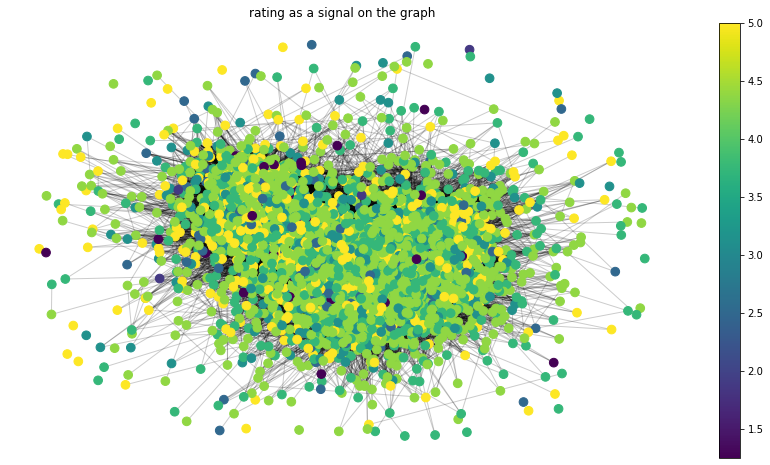

In [12]:
visualize_graph(graph,'rating', k=0.1, alpha=0.2, node_shape='.')

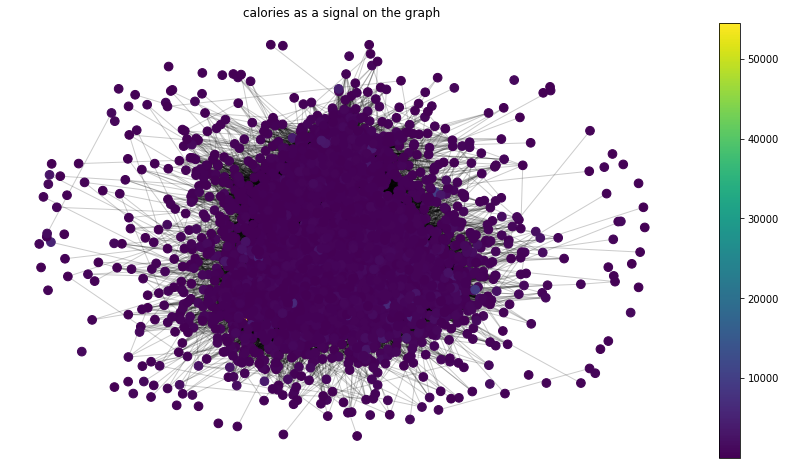

In [13]:
visualize_graph(graph,'calories', k=0.1, alpha=0.2, node_shape='.')

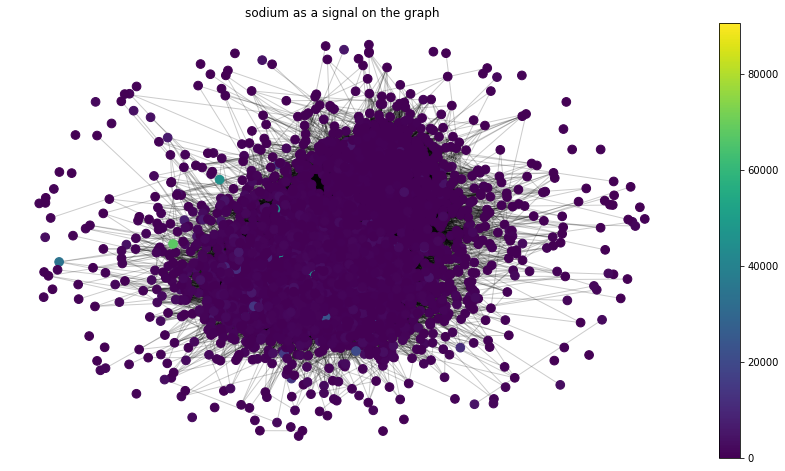

In [14]:
visualize_graph(graph,'sodium', k=0.1, alpha=0.2, node_shape='.')

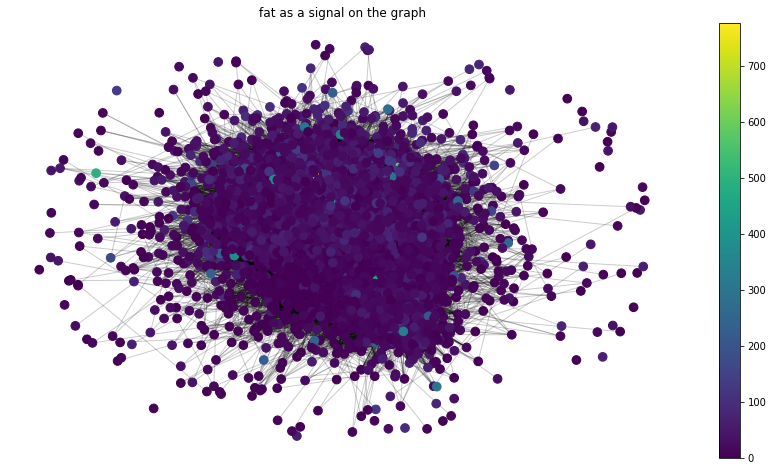

In [15]:
visualize_graph(graph,'fat', k=0.1, alpha=0.2, node_shape='.')

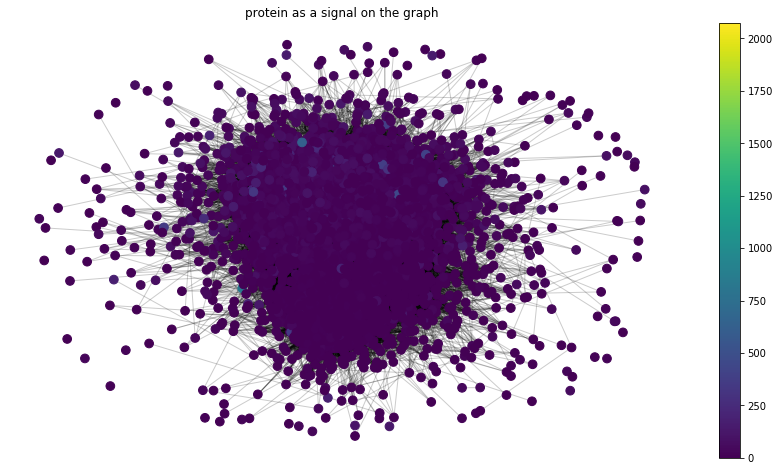

In [16]:
visualize_graph(graph,'protein', k=0.1, alpha=0.2, node_shape='.')

One of the interesting questions that one may think of is the following: **_Do similar recipes tend to have similar ratings?_**

Given our graph, to answer this question we can simply calculate attribute assortativity coefficient for 'rating', which measures the similarity of connections in the graph with respect to the 'rating' attribute.

In [17]:
nx.attribute_assortativity_coefficient(graph, 'rating')

0.014118448650154694

As we can see the number is quite small indicating that in general similar recipes do not have similar ratings.

### Community detection

Given our graph, it is extremely interesting to investigate the different clusters and their properties it contains. For this purpose we are going to use the **_Louvain method_**, which is one of the most famous algorithms for commuity detection.

In [41]:
partition = community_louvain.best_partition(graph, random_state=42)

In [42]:
print('Total number of clusters found: {}'.format(max(partition.values())+1))

Total number of clusters found: 54


Let's add as a node attribute the cluster label obtained from the partition by the Louvain method

In [43]:
nx.set_node_attributes(graph, partition, 'cluster')

Now, let's visualize the different clusters

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


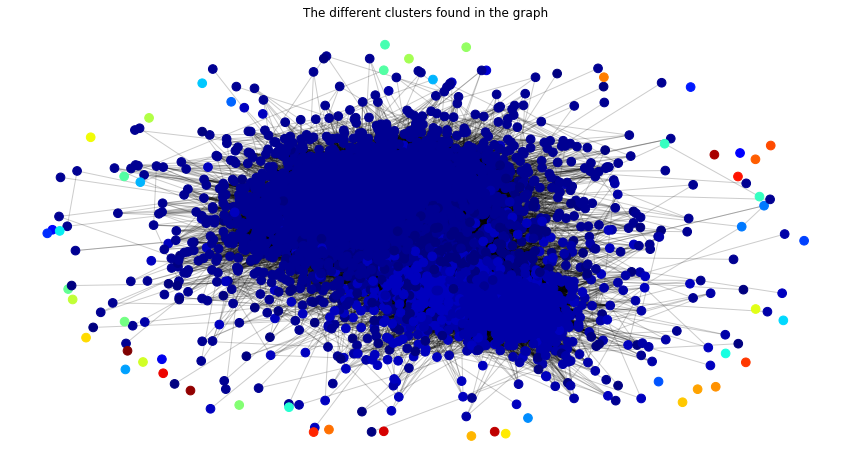

In [44]:
plt.figure(figsize=(15,8))
plt.title('The different clusters found in the graph')
pos = nx.spring_layout(graph,k=0.1)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes(), node_color=[graph.nodes[n]['cluster'] for n in graph.nodes()], 
                            with_labels=False, node_shape='.', cmap=plt.cm.jet)
plt.axis('off')
plt.show()

Let's print the number of nodes in each cluster.

In [46]:
Counter(partition.values())

Counter({0: 427,
         1: 3094,
         2: 1045,
         3: 380,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         11: 1,
         12: 1,
         13: 2,
         14: 1,
         15: 1,
         16: 2,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 2,
         23: 1,
         24: 2,
         25: 1,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 1,
         34: 1,
         35: 1,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1})

Let's take the big clusters and investigate the properties shared within each individual cluster.

In [47]:
# Take all the nodes that belong to the 0th, 1st, 2nd, and 3rd clusters respectively
cluster_0 = [k for k in graph.nodes if partition[k] == 0]
cluster_1 = [k for k in graph.nodes if partition[k] == 1]
cluster_2 = [k for k in graph.nodes if partition[k] == 2]
cluster_3 = [k for k in graph.nodes if partition[k] == 3]

In [48]:
for each in cluster_0:
        print(node_label_mapping[each])

Goat Cheese Marinated in Rosemary, Fennel, and Hot Red Pepper
Parmesan-Roasted Butternut Squash
Mashed Potatoes with Cheddar Cheese and Poblano Chilies
Cheddar and Chive Rounds
Sweet Potato and Sausage Gratin with Thyme
Scrambled Eggs with Sausage and Thyme
Beef and Potato Pasties
Baked Grits with Ham, Wild Mushrooms and Parmesan
Creamed Spinach with Golden Breadcrumb Topping
Caramelized-Onion Dip with Cilantro-Garlic Pita Crisps
Vidalia Onion Pie
Herbed Oven-Browned Potatoes
Shoe String Potatoes (Pommes Pailles)
Zucchini Potato Lemon-Thyme Mash
Cauliflower and Caramelized Onion Tart
Blue and Red Flannel Hash
Potato, Onion and Caraway Cloverleaf Rolls
Baked Fish Fillets with Spinach-Pine Nut Topping
Polenta
Creamed Spinach with Chère
Fettuccine Quatro Formaggi
Bacon, Arugula, Tomato, and Egg Sandwiches
Goat Cheese, Date, and Bacon Strudels
Peppery Pasta Carbonara with Poached Egg
Horseradish Mashed Potatoes
Apple Raisin Bread Pudding
Broiled Salmon Steaks with Horseradish Crust
Spinach

TO BE EXPLAINED BY THE GIRLS...

In [49]:
for each in cluster_1:
        print(node_label_mapping[each])

Croatian Moussaka
Ann Pachett's Spicy Seafood Chowder
Wilted Red Cabbage with Balsamic Vinegar
Sausage, Cranberry, and Pecan Stuffing
Basic Tomato Sauce
Steak au Poivre
Portuguese Baked Eggs
Pork Chops with Mustard Crumbs
Gingered Plum Barbeque Sauce
Grilled Vegetables with Cumin, Cilantro, and Salsa Verde
Clams au Gratin
Coffee-Rubbed Cheeseburgers with Texas Barbecue Sauce
Marmalade-Glazed Spareribs
Veal Scallops with Lemon and Capers
Apple and Raisin Slaw
Sausages with Sherry Caramel Glazed Pears
Seared Steak Lettuce Cups
Mexican Meatball Soup with Rice and Cilantro
Chinese Barbecued Spareribs
Pigeon-Pea Soup
Roast Chicken With Harissa And Schmaltz
Rosé's Baccalà Salad
Beet, Fennel and Watercress Salad
Castellane Pasta with Sausage, Peppers, Cherry Tomaotes, and Marjoram
Bacon, Cabbage and Gruyère Pizza
Viennese Cucumber Salad
Curried Cheddar Date Bites
Old-Fashioned Chicken and Corn Stew
Avocado and Tropical-Fruit Salsa
Lamb Chops with Mushroom Wine Sauce
Lobster Salad with Summer 

Clam and Cod Chowder
Curried Turkey Salad with Cashews
Eggplant and Spinach Lasagne Spirals
Smoked Duck Toasts with Gingered Rhubarb
Nectarine Salsa
Roasted Potato, Garlic, and Red Pepper Salad
Grilled Fontina with Artichokes and Mushrooms
Pan Bagnat
Fried Chicken Sandwich with Slaw and Spicy Mayo
Sausage and Bean Soup
Salmon, Mustard Greens and Potatoes with Mustard-Dill Glaze
Pizza 6: Pan-fried Hawaiian Pizza
Pasta with Shrimp and Basil Vinaigrette
Herb and Onion Stuffing
Seafood Chowder with Squash
Crab Salad Sandwiches
Cranberry Sauce with Roasted Shallots and Port
Corn and Bell Pepper Salad
Roasted Potatoes with Garlic, Lemon, and Oregano
Braised and Roasted Pork Shanks With Prosciutto and Porcini Mushrooms
Sashimi Salad with Soy and Orange
Beef Bourguignonne Pot Pie
Halibut with Herb Sauce
Grilled Chicken Breast Stuffed with Prosciutto and Basil
Mexican Pasta with Black Beans
Goat Cheese and Tomato Tart
Truffled French Fries
Sweet Potato Salad with Chili-Lime Dressing
Lentil Soup

TO BE EXPLAINED BY THE GIRLS...

In [50]:
for each in cluster_2:
        print(node_label_mapping[each])

Applesauce Spice Muffins
Apple and Fig Custard
Bread Pudding with Bourbon Sauce
Plum Oatmeal Crisp
Banana-Chocolate Chip Cake With Peanut Butter Frosting
Warm Pear Shortcakes with Brandied Cream
Asparagus Flans
Concord Grape and Pear Pie
Coffee S'mores Pie
Pears Poached in Red Wine, Cardamom and Orange
Mascarpone Cheesecake Tart with Nectarines
White Chocolate and Orange Soufflé
Pavlova Pyatt
No-Bake Lemon Cream Tart
Butterscotch, Walnut and Coffee Bread Pudding
Marbled Mint-Chocolate Pudding
Strawberry-Lemon Cream Tart
Hot Chocolate Baked French Toast
Diner-Style French Toast
Scarborough Fair Shortbread
Sweet Potato Turnovers with Sweet Kraut
Lemon Chiffon Pie with Glazed Cranberries
Caviar and Salmon Blini Tortes
Swedish Meringue Cake with Strawberries and Orange Filling
Paleo Granola With Coconut and Almonds
Sweet Yogurt Cheese with Minted Strawberries
Lemon Blueberry Cobbler
Sour Cream and Herb Muffins
Mocha Sheet Cake with Pecans
Candied Fig, Hazelnut and Orange Cheesecake with Po

TO BE EXPLAINED BY THE GIRLS...

In [51]:
for each in cluster_3:
        print(node_label_mapping[each])

Limonada
White Wine and Peach Sangria
Pluot and Prosecco Fizz
Beer-Braised Hot Dogs with Braised Sauerkraut
Carrot, Apple, and Horseradish Salad
Coconut Mango Sorbet
Strawberry Banana Margarita
Fried Oysters with Holiday Tartar Sauce
Citrus Syrup
Yogurt-Peach Semifreddo
Cranberry Relish with Grapefruit and Mint
Prosciutto-Artichoke Sandwiches with Rosemary Mayonnaise
Lemon Crystal Forty-Three
Linguine with Carrot Ribbons and Lemon-Ginger Butter
Chilled Avocado and Zucchini Soup
Cantaloupe Granita
Poached Asian Pears with Star Anise and Tropical Fruit
Plum Chutney
Fish House Punch
Pineapple Sangria
Baked Ham with Mustard-Red Currant Glaze and Rhubarb Chutney
Spiced Grilled Cornish Hen
Vietnamese Caramelized Grilled Pork
Roasted Red Pepper Butter
Snap Pea Salad
Barbary Coast
Orange Shallot Mayonnaise
Watermelon-Mint Ice Cubes
Cassis-Spiked Cranberry Sauce
Orange and Banana Yogurt Smoothie
New England Crab Rolls
Cranberry, Pomegranate, and Meyer Lemon Relish
Fresh Strawberry Sorbet with S

TO BE EXPLAINED BY THE GIRLS...

### Simple recommender system based on KNN

In [52]:
def get_top_n_recs(dish_list, k, n):
    """
    Give top-n recommendations given a list of dishes.

    Parameters
    ----------

    dish_list: list
        List of dish names
        
    n: int
        Number of recommendations to show
    
    k: int 
        Number of neighbors to use
    """
    
    dish_list = [label_node_mapping[each] for each in dish_list]
    
    d = {elem: graph.node[elem]['rating'] for elem in dish_list}
    k_neighbours = [each[0] for each in sorted(d.items(), key=itemgetter(1), reverse=True)[:k]]
    candidates = defaultdict(float)
    
    for each in k_neighbours:
        for i, elem in enumerate(adjacency_matrix[each]):
            candidates[i]+=elem

    print('The top {} recommendations are the following:'.format(n))
    count = 1
    for index, score in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        print(node_label_mapping[index])
        if count >= n:
            break
        count += 1

In [53]:
dish_list = ['Mocha Custard Tart','Lemon Cream Pie','Glazed Apple Rings','Watermelon-Berry Granita',
            'Strawberry Compote','Orange Rice Pudding','Midori Melon Ice Pops','Cranberry Kir',
             'Strawberry-Banana Smoothie']

get_top_n_recs(dish_list,k=5,n=5)

The top 5 recommendations are the following:
Watermelon Daiquiri
Fresh Pineapple and Rum Punch
Mocha Custards
Café con Leche and Chocolate Cheesecake
Black-Bottom Raspberry Cream Pie


<font color='red'>What are the main nutritional factors affecting people’s culinary preferences? TBC...</font>

In [ ]:
def rating_to_category(rating):
    if rating < 3:
        return 0 # low rating
    elif rating < 4:
        return 1 # medium rating
    else:
        return 2 # high rating

In [ ]:
data_recipe['rating_categories'] = data_recipe['rating'].apply(rating_to_category)

In [ ]:
data_recipe.rating_categories.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import csgraph

In [ ]:
features = data_recipe[['fat','calories','protein','sodium']]
labels = data_recipe.rating_categories

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
X_train.shape,X_test.shape,X_val.shape

In [ ]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [ ]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

In [ ]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

In [ ]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    eig_val, eig_vec = np.linalg.eigh(laplacian)
    idx = eig_val.argsort() 
    lamb = eig_val[idx]
    U = eig_vec[:,idx]
    return lamb,U

In [ ]:
laplacian = csgraph.laplacian(adjacency_matrix,normed=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(lam)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [ ]:
ideal_filter = np.ones((5000,))
ideal_filter[lam >= 0.2] = 0

In [ ]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    V = np.vander(lam,N=order,increasing=True)
    return np.linalg.lstsq(V,spectral_response)[0]

In [ ]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    V = np.vander(lam,N=coeff.shape[0],increasing=True)
    return np.dot(V,coeff)

In [ ]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    L_k = [np.linalg.matrix_power(laplacian,k) for k in range(len(coeff))]
    res = np.zeros(laplacian.shape)
    for index,each in enumerate(L_k):
        res+=coeff[index]*each
    return res

In [ ]:
order = 7

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

In [ ]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

In [ ]:
new_features = graph_filter @ features

X_train, X_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
C = np.logspace(0,6)
scores = []

for c in C:
    model_logit = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c, random_state=42)
    model_logit.fit(X_train,y_train)
    scores.append(model_logit.score(X_val,y_val))

In [ ]:
c_best = C[np.argmax(scores)]
model_logit_best = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000, C=c_best, random_state=42)
model_logit_best.fit(X_train,y_train)

In [ ]:
train_acc =  model_logit_best.score(X_train,y_train)
val_acc =  model_logit_best.score(X_val,y_val)
test_acc =  model_logit_best.score(X_test,y_test)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

In [ ]:
model_logit_best.predict_proba(X_train)